# Agent Birth Rate Calibration and Beyond

The aim of this notebook is to use the data provided to find a calibrated value for agent birth rate in the model.
In this context, we take agent birth rate to mean the rate at which pedestrian agents are activated to enter the model environment, i.e. the station concourse.
We can think of this as the number of pedestrians that may enter through the gates located at the edge of the model environment at each time-step/frame.

With a lower birth rate, the number of pedestrians in the system is likely to remain consistently low, and as a consequence instances where pedestrians interact with each other will be infrequent.
With a higher birth rate, the number of pedestrians in the system is likely to increase quickly, and we may therefore observe some crowding with agents being forced to interact with each other and find ways past each other.
The level of crowding and interaction that we observe in a system will vary from scenario to scenario.
In order for our model to accurately represent the behviour that we observe in the real-world system, we need to ensure that the parameter values that we use are accurate - this notebook therefore focuses on identifying a value for the `birth_rate` parameter, using the parameter values that we found in [the previous notebook](./2_speed_calibration.ipynb).

## Imports

As always, we will start by importing all of the necessary packages, including the `StationSim` model:

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sys import path
import time
from tqdm import tqdm

%matplotlib inline

In [2]:
path.append('../src/model/')
from stationsim_gcs import Model

## Paths and Directories

Define some paths to and from data:

In [3]:
combined_frames_path = '../data/outputs/combined_frames.csv'

In [4]:
output_data_dir = '../data/outputs/'

## Functions

Here, I have defined some functions that will be useful later in the analysis:

In [5]:
def get_number_pedestrians_in_frame(df, frame):
    """
    Find the number of pedestrians in a frame.
    
    df: pandas dataframe
    frame: int
    
    returns: int
    
    Given a dataset of all pedestrian locations in all frames,
    restrict the dataset down to the frame in question,
    and count the number of unique pedestrians IDs.
    """
    tdf = df.loc[df['frame']==frame, :]
    return len(tdf['pedestrianID'].unique())

In [6]:
def __get_error(observed, model, variable):
    """
    Calculate the error between an observed value and a value from the model.
    
    observed: dict-like
    model: dict-like
    variable: str
    
    returns: numerical
    
    Given a dictionary of metrics from the observed data,
    a dictionary of metrics from the model data
    and a string indicating the variable of interest,
    calculate the error, i.e. the difference between the two.
    """
    return observed[variable] - model[variable]

In [7]:
def get_error(observed_results, model_results):
    """
    Calculate errors based on observed metrics and model metrics.
    
    observed_results: dict-like
    model_results: dict-like
    
    returns: dict
    
    Given a dictionary of observed metrics from the data and a
    dictionary of metrics from the model, calculate the error in:
    - the maximum number of pedestrians in the system at any one time
    - the time at which the maximum occurs
    - the total time taken for all pedestrians to complete their journeys
    """
    n_max_peds = __get_error(observed_results, model_results, 'n_max_active_pop')
    t_max_peds = __get_error(observed_results, model_results, 't_max_active_pop')
    t_max = __get_error(observed_results, model_results, 't_max')
    
    results = {'n_max_active_pop': n_max_peds,
               't_max_active_pop': t_max_peds,
               't_max': t_max,
               'rate': model_results['rate']}
    return results

## Analysis

We start our analysis by reading in the data pertaining to the paths of pedestrians across the concourse:

In [8]:
# Read in data
data = pd.read_csv(combined_frames_path)
data.head()

,frame,pedestrianID,x,y
0,5327,245,563.110625,676.817906
1,5327,246,534.003343,631.251565
2,462,198,49.431612,296.911898
3,462,199,539.377299,88.443098
4,462,208,486.787285,560.910907


As we saw in the previous notebook, this dataset is made up fo observations pertaining to 4 columns:
* `frame`, i.e. the frame in which the observation was captured,
* `pedestrianID` i.e. the unique pedestrian that the observation relates to,
* `x`, i.e. the $x$-coordinate of the pedestrian within the concourse in the frame,
* `y`, i.e. the $y$-coordinate of the pedestrian within the concourse in the frame.

### Exploring the variation in number of pedestrian in the real system over time

Given the data that we have regarding the real-world system, we are able to find the number of pedestrians present in the concourse in any given frame, and explore how this varies over time (i.e. frame by frame).
We will also be able to produce a similar set of data from a model run.
This is an important way in which we can compare the extent to which our model behaves like the real-world system.

Let us, therefore, begin by creating a dataset of how many pedestrians are found in each of the frames in the data:

In [9]:
# Identify the unique frame numbers in our data
frame_numbers = data['frame'].unique()

# Create an empty list in which to store the number of pedestrians found in each frame
pedestrians_per_frame = list()

# Iterature through each frame, finding the number of pedestrians observed
for frame_number in frame_numbers:
    d = {'frame': frame_number,
         'n_pedestrians': get_number_pedestrians_in_frame(data, frame_number)}
    pedestrians_per_frame.append(d)

# Create a dataframe from the results, sorting by frame number
pedestrians_per_frame = pd.DataFrame(pedestrians_per_frame).sort_values(by='frame')

pedestrians_per_frame.head()

,frame,n_pedestrians
3441,0,1
318,1,1
988,2,1
951,3,1
539,4,1


Given the DataFrame `pedestrians_per_frame`, produce a plot showing how the number of pedestrians in the system varies frame by frame:

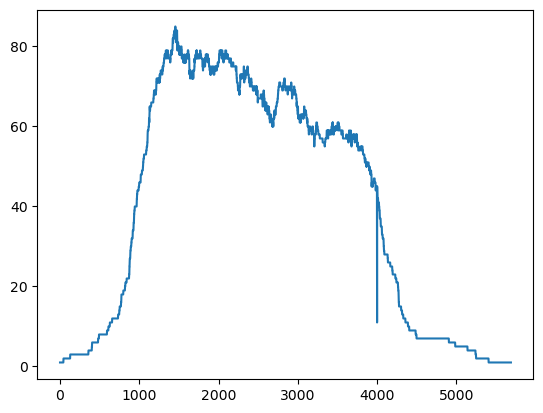

In [11]:
# Insert code here
plt.figure()
plt.plot(pedestrians_per_frame["frame"], pedestrians_per_frame["n_pedestrians"])
plt.xlabel("Time (frames)")
plt.ylabel("Number of active pedestrians")
plt.show()

Given the above data and visualisation, we can calculate:
* the maximum number of pedestrians in the system at any given time
* the time at which this maximum occurs
* the time it takes for all pedestrians to complete their journeys

Each of these are metrics for which we can calculate corresponding values from a model run for comparison.
Let us find them for the observational data.

From the above data and visualisation, can we work out what the maximum number of pedetrians is in the system at any given time?

In [12]:
# Insert code here
np.max(pedestrians_per_frame["n_pedestrians"])

85

From the above data and visualisation, can we work out when the system contains this maximum number of pedetrians?

In [14]:
# Insert code here
pedestrians_per_frame.loc[pedestrians_per_frame["n_pedestrians"]==85, :]

,frame,n_pedestrians
3832,1453,85
3436,1454,85
3910,1455,85


From the above data and visualisation, can we work out how many frames it takes all of the pedestrians to complete their journeys across the concourse?

In [15]:
# Insert code here
np.max(pedestrians_per_frame["frame"])

5687

### Comparing real data with the model

Now that we have calculated all of the necessary information from the observation (real) data, we would like to compare our model against the data.
The plan for doing this is:
1. Create a dictionary of model parameters
2. Create an instance of the model with the model parameter dictionary
3. Run the model to completion
4. Compare the model to the observational data

We start by creating a dictionary of model parameters (as in [the previous notebook on running models](./1_running_models.ipynb)) with the following parameter values:

* `station`: `Grand_Central`
* `step_limit`: 20000
* `do_print`: `False`
* `pop_total` number of pedestrians found in previous notebook
* `speed_mean`: value found in previous notebook
* `speed_std`: value found in previous notebook
* `speed_min`: value found in previous notebook

In [17]:
# Insert code here
# Replace None with a dictionary of parameter values
model_params = {"station": "Grand_Central",
                "step_limit": 20000,
                "do_print": False,
                "pop_total": 274,
                "speed_mean": 1.6026400144010877,
                "speed_std": 0.6642343305178545,
                "speed_min": 0.31125359137714953}

The parameter that we want to find the value for in this notebook is `birth_rate` - let's try running the model with a birth rate of $1.0$.
We start by adding the parameter value to our dictionary.

In [18]:
# Insert code here
# Replace None with the birth rate for which you would like to run the model
birth_rate = 1.0

# Set birth rate value
model_params['birth_rate'] = birth_rate

We now create an instance of the model with our model parameter dictionary:

In [19]:
# Create model based on model parameters
model = Model(**model_params)

And finally we run the model.
Note that this instance of running the model forward may appear more complicated than that [shown previously](./1_running_models.ipynb), but this is still the same process: use a for loop to iterate the model forward.
Reading through the code, you will see that the additional code aims to calculate data that we can use to compare against the observation data above.

WARNING, RUNNING THE MODEL WITH THIS NUMBER OF PEDESTRIAN MAY TAKE A COUPLE OF MINUTES

In [20]:
# Create an empty list in which to collect results
population_results = list()

n_max_active_pop = 0
t_max_active_pop = 0
t_max = False

# Iterate the model forward
for _ in tqdm(range(model.step_limit)):
    # Step model forward
    model.step()
    
    # Calculate number of pedestrians in system for this frame
    timestep_results = {'frame': model.step_id,
                        'active_pedestrians': model.pop_active}
    population_results.append(timestep_results)

    # Update max_active_pop
    if model.pop_active > n_max_active_pop:
        n_max_active_pop = model.pop_active
        t_max_active_pop = model.step_id

    # get t_max
    if not t_max and model.step_id > 1000 and model.pop_active == 1:
        t_max = model.step_id

model_metrics = {'n_max_active_pop': n_max_active_pop,
                 't_max_active_pop': t_max_active_pop,
                 't_max': t_max,
                 'rate': birth_rate}

100%|██████████████████████████████████████████████████████████████| 20000/20000 [00:47<00:00, 418.28it/s]


Once the model has run, we can convert the results regarding the size of the active population in the model into a DataFrame:

In [21]:
# Convert list of population results into a Pandas dataframe
population_results = pd.DataFrame(population_results)
population_results.head()

,frame,active_pedestrians
0,1,0
1,2,1
2,3,1
3,4,1
4,5,1


Now that the model has run, let us have a look at the model metrics that have been produced:

In [22]:
model_metrics

{'n_max_active_pop': 31, 't_max_active_pop': 3601, 't_max': 8515, 'rate': 1.0}

In this situation, `n_max_active_pop` is the maximum number of pedestrians in the system at any given time, `t_max_active_pop` is the time at which this maximum value occurred and `t_max` is the time taken for all of the pedestrian agents to complete their journeys.

How do these compare to what we observe in the data? Consider discussing this with your group. 

Note that you will each have different results, but will hopefully observe the same qualitative differences between your results and the observational data. Why should each of your results be different? If unsure, discuss with Natacha or Keiran

(INSERT OBSERVATIONS HERE)

* Max number of pedestrians in the system is much higher in the data than in the model
* Time at which max pedestrians occurs is later in the model than in the data
* Time taken for all pedestrians to leave the environment is greater in the model than in the data 

We can also plot the variation in the number of active pedestrian agents in the system over time, and compare this to how the number of pedestrians in the concourse varies over time in the data:

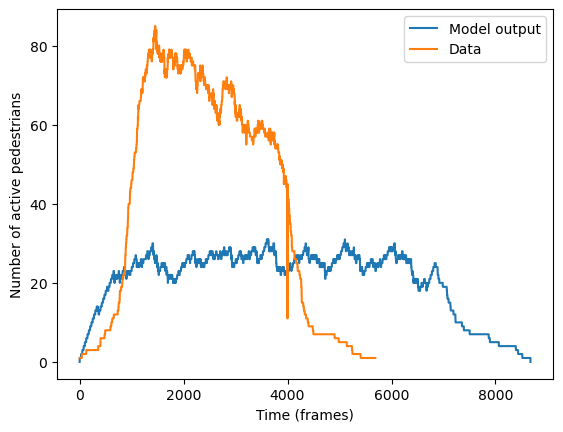

In [24]:
# Insert code here
# Produce a line plot of pedestrians_per_frame and overlay a line plot of population_results
plt.figure()
plt.plot(population_results["frame"],
         population_results["active_pedestrians"],
         label="Model output")
plt.plot(pedestrians_per_frame["frame"],
         pedestrians_per_frame["n_pedestrians"],
         label="Data")
plt.xlabel("Time (frames)")
plt.ylabel("Number of active pedestrians")
plt.legend()
plt.show()

What can we learn from this plot about the behaviour of the model in comparison to the observed data?

(INSERT OBSERVATIONS HERE)

* The number of pedestrians in the system is generally lower in the model than in the data.
* The number of pedestrians in the system is relatively consistent over the course of the simulation whereas the number of pedestrians in the system in the data has a noticeable maximum
* It takes longer for all of the pedestrians to leave the system in the model in comparison to those in the data

### Exploration

At this stage, we can hopefully agree that, when using a `birth_rate` of $1.0$, the model does not behave in a manner that reflects what we observe in the data.
If we compare our results with those of our neighbours, we may also observe that there is some variability between different model runs.
This leads us on to the final section of the practicals - an open-ended exploration of the model in comparison to the observational data.
Some ideas that you could consider for your investigation might be
* Finding the correct value of `birth_rate` (calibration):
    * Running the model for different birth rates, and comparing results via visualisations
    * Running the model for different birth rates, and comparing results via numerical metrics
* Exploring variability in the model (sensitivity analysis):
    * Running the model multiple times for the same birth rates to explore how the model visualisations vary between runs
    * Running the model multiple times for the same birth rates to explore how the numerical model metrics vary between runs
* Exploring the qualitative behaviour of the model (validation):
    * Producing animations of the observed data and animations of the model for different birth rates to explore how the behaviours compare

You are, however, very welcome to take your investigations in different directions.
If you have an idea, but are unsure about it then feel free to run it by Natacha or Keiran.

In [ ]:
# Insert code here
